In [43]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs

In [72]:
# EXPERIMENT
kg_to_1000tonnes = 1e-6
day_per_year = 365
ktonnes_to_hg = 1e7


FPi_nodes = {'FLOi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Food losses per food group'},
             'FDKGi': {'type': 'input',
                       'unit': 'kg/capita/day',
                       'name': 'Kg food demand per day per food group'},
             'SSRi': {'type': 'input',
                      'unit': '1',
                      'name': 'Self-sufficiency ratio per food group',
                      },
             'FDPi': {'type': 'variable',
                      'unit': '1000 tonnes',
                      'name': 'Total food production per food group',
                      'computation': lambda FDKGi, Pop, FLOi, **kwargs: kg_to_1000tonnes * day_per_year * FDKGi * Pop * 1e3 + FLOi
                      },
             'OFi': {'type': 'variable',
                     'unit': '1000 tonnes',
                     'name': 'Other food demand',
                     'computation': lambda SDi, NFDi, PDi, RDi, SVi, **kwargs: SDi + NFDi + PDi + RDi + SVi
                     },
             'SDi': {'type': 'input',
                     'unit': '1000 tonnes',
                     'name': 'Seed demand per food group'},
             'NFDi': {'type': 'input',
                      'unit': '1000 tonnes',
                      'name': 'Non-food demand per food group'},
             'PDi': {'type': 'input',
                     'unit': '1000 tonnes',
                     'name': 'Processed demand per food group'},
             'RDi': {'type': 'input',
                     'unit': '1000 tonnes',
                     'name': 'Residual demand per food group'},
             'SVi': {'type': 'input',
                     'unit': '1000 tonnes',
                     'name': 'Stock variation per food group'},
             'FPi': {'type': 'output',
                     'name': 'Food production per food group',
                     'unit': '1000 tonnes',
                     'computation': lambda SSRi, OFi, FDi, FDPi, **kwargs: (OFi + FDi + FDPi) * SSRi
                     },
             'FDi': {'type': 'input',
                     'unit': '1000 tonnes',
                     'name': 'Feed demand per food group'},
             'Pop': {'type': 'input', 'unit': 'capita', 'name': 'Population'}}

TCLDi_nodes = {'TCLDi': {'type': 'output',
                         'name': 'Cropland demand',
                         'unit': 'ha',
                         'computation': lambda CYi, FPi, **kwargs: ktonnes_to_hg * FPi / CYi
                         },
               'CYi': {'type': 'input',
                       'unit': 'hg/ha',
                       'name': 'Crop yields per crop type'},
               'FPi': {'type': 'input',
                       'name': 'Food production per food group',
                       'unit': '1000 tonnes'},
               }

CH_IL_FL_nodes = {'TCLD_baseline': {'type': 'input',
                                    'unit': 'ha',
                                    'name': 'Cropland demand baseline'},
                  'TCLDi': {'type': 'input',
                            'unit': 'ha',
                            'name': 'Cropland demand'},
                  'chCL': {'type': 'variable', 'name': 'Change in cropland', 'unit': '1000 ha',
                           'computation': lambda TCLDi, TCLD_baseline, **kwargs: 1e-3 * (TCLDi.sum() - TCLD_baseline)
                           },
                  # 'CL_t_minus_1': {'type': 'input', 'unit': '1000 ha', 'name': 'Cropland t-1'},
                  'IL_t_minus_1': {'type': 'input',
                                   'unit': '1000 ha',
                                   'name': 'Inactive land t-1'},
                  'FL_t_minus_1': {'type': 'input',
                                   'unit': '1000 ha',
                                   'name': 'Forest land t-1'},
                  # 'CL_t': {'type': 'output',
                  #          'name': 'Cropland stock',
                  #          'unit': '1000 ha',
                  #          'computation': lambda chCL, CL_t_minus_1, **kwargs: chCL + CL_t_minus_1
                  #          },
                  'IL_t': {'type': 'output',
                           'name': 'Inactive land stock',
                           'unit': '1000 ha',
                           'computation': lambda chCL, IL_t_minus_1, **kwargs: IL(chCL, IL_t_minus_1)
                           },
                  'FL_t': {'type': 'output',
                           'name': 'Forest land stock',
                           'unit': '1000 ha',
                           'computation': lambda chCL, FL_t_minus_1, IL_t_minus_1, **kwargs: FL(chCL, FL_t_minus_1, IL_t)
                           }
                  }

BE2_nodes = {'TLA': {'type': 'input', 'unit': '1000 ha', 'name': 'Total land area'},
             'FL_t': {'type': 'input', 'unit': '1000 ha', 'name': 'Forest land stock'},
             'IL_t': {'type': 'input', 'unit': '1000 ha', 'name': 'Inactive land stock'},
             'R_rate': {'type': 'parameter', 'unit': '%', 'name': 'Rate of reforestation'},
             'RF_land': {'type': 'variable',
                         'name': 'Reforestation of land',
                         'unit': '1000 ha',
                         'computation': lambda R_rate, IL_t, **kwargs: R_rate * 1e-2 * IL_t
                         },
             'FL_RF': {'type': 'variable',
                       'name': 'Forest land stock after reforestation policy',
                       'unit': '1000 ha',
                       'computation': lambda FL_t, RF_land, **kwargs: FL_t + RF_land
                       },
             'IL_RF': {'type': 'variable',
                       'name': 'Inactive land stock after reforestation policy',
                       'unit': '1000 ha',
                       'computation': lambda IL_t, RF_land, **kwargs: IL_t - RF_land
                       },
             'BE2': {'type': 'output',
                     'name': 'Share of forest area to total land area',
                     'unit': '%',
                     'computation': lambda FL_RF, TLA, **kwargs: 1e2 * FL_RF / TLA
                     }
             }


TAi_nodes = {'FPi': {'type': 'input',
                     'unit': '1000 tonnes',
                     'name': 'Food production per food group'},
             'AYi': {'type': 'input',
                     'unit': 'tonnes/head',
                     'name': 'Vector of animal yields'},
             'ANPi': {'type': 'variable',
                      'unit': 'head',
                      'name': 'Vector animals needed for production',
                      'computation': lambda FPi, AYi, **kwargs: FPi / AYi
                      },
             'PTTAi': {'type': 'parameter',
                       'unit': '1',
                       'name': 'vector production-to-total animals ratio',
                       },
             'TAi': {'type': 'output',
                     'unit': 'head',
                     'name': 'Total animal population',
                     'computation': lambda ANPi, PTTAi, **kwargs: PTTAi * ANPi.groupby(level=['ISO', 'Year', 'emi_item']).sum().rename_axis(index={"emi_item": 'Item'})
                     },
             }


TMi_nodes = {'TAi': {'type': 'input', 'unit': 'head', 'name': 'Total animal population'},
             'MYi': {'type': 'input', 'unit': 'kgN/head', 'name': 'Manure yields'},
             'TMi': {'type': 'output',
                     'unit': 'kgN',
                     'name': 'Total Manure (N content)',
                     'computation': lambda TAi, MYi, **kwargs: TAi * MYi
                     }
             }

M_xi_nodes = {'TMi': {'type': 'input',
                              'unit': 'kgN',
                              'name': 'Total Manure (N content)'},
              'MM_ASi': {'type': 'input',
                         'unit': '1',
                         'name': '% Manure applied to soils'},
              'MM_LPi': {'type': 'input',
                         'unit': '1',
                         'name': '% Manure left on pasture'},
              'MM_Ti': {'type': 'input',
                        'unit': '1',
                        'name': '% Manure treated'},
              'M_Ti': {'type': 'output',
                       'unit': 'kgN',
                       'name': 'Manure treated (N content)',
                       'computation': lambda MM_Ti, TMi, **kwargs: MM_Ti * TMi

                       },
              'M_LPi': {'type': 'output',
                        'unit': 'kg',
                        'name': 'Manure left on pasture (N content)',
                        'computation': lambda MM_LPi, TMi, **kwargs: MM_LPi * TMi

                        },
              'M_ASi': {'type': 'output',
                        'unit': 'kgN',
                        'name': 'Manure applied to soils (N content)',
                        'computation': lambda MM_ASi, TMi, **kwargs: MM_ASi * TMi

                        }
              }

TMP_CO2eq_nodes = {'M_LPi': {'type': 'input',
                             'unit': 'kg',
                             'name': 'Manure left on pasture (N content)'},
                   'EF_Li': {'type': 'parameter',
                             'unit': 'kg N2O-N/kg N',
                             'name': 'Implied emission factor for N2O (Manure on pasture)'
                             },
                   'TMP_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure on pasture)',
                                 'computation': lambda M_LPi, EF_Li, **kwargs: kg_to_Gg * N2ON_to_NO2 * GWPN2O * (M_LPi * EF_Li)
                                 }
                   }

TMT_CO2eq_nodes = {'M_Ti': {'type': 'input',
                            'unit': 'kgN',
                            'name': 'Manure treated (N content)',
                            },
                   'EF_Ti': {'type': 'parameter',
                             'unit': 'kg N2O-N/kg N',
                             'name': 'Implied emission factor for N2O (Manure management)'},
                   'EF_CH4Ti': {'type': 'parameter',
                                'unit': 'kg/head',
                                'name': 'Implied emission factor for CH4 (Manure management)'},
                   'TAi': {'type': 'input',
                           'unit': 'head',
                           'name': 'Total animal population'},
                   'E_Ti': {'type': 'variable',
                            'unit': 'gigagrams',
                            'name': 'Emissions (N2O) (Manure management)',
                            'computation': lambda EF_Ti, M_Ti, **kwargs: N2ON_to_NO2 * kg_to_Gg * (EF_Ti * M_Ti)
                            },
                   'E_TCH4i': {'type': 'variable',
                               'unit': 'gigagrams',
                               'name': 'Emissions (CH4) (Manure management)',
                               'computation': lambda EF_CH4Ti, TAi, **kwargs: kg_to_Gg * (EF_CH4Ti * TAi)
                               },
                   'TMT_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure management)',
                                 'computation': lambda E_Ti, E_TCH4i, **kwargs: E_Ti * GWPN2O + E_TCH4i * GWPCH4
                                 }}

TMA_CO2eq_nodes = {'M_ASi': {'type': 'input',
                             'unit': 'kgN',
                             'name': 'Manure applied to soils (N content)',
                             },
                   'EF_ASi': {'type': 'parameter',
                              'unit': 'kg N2O-N/kg N',
                              'name': 'Implied emission factor for N2O (Manure applied)'},
                   'TMA_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Manure applied)',
                                 'computation': lambda EF_ASi, M_ASi, **kwargs: GWPN2O * N2ON_to_NO2 * kg_to_Gg * (EF_ASi * M_ASi)
                                 }
                   }

TEE_CO2eq_nodes = {'EF_EEi': {'type': 'input',
                              'unit': 'kg CH4 / head',
                              'name': 'Implied emission factor for CH4 (Enteric)'},
                   'TAi': {'type': 'input',
                           'unit': 'head',
                           'name': 'Total animal population'},
                   'TEE_CO2eq': {'type': 'output',
                                 'unit': 'gigagrams (CO2eq)',
                                 'name': 'Emissions (CO2eq) (Enteric)',
                                 'computation': lambda TAi, EF_EEi, **kwargs: kg_to_Gg * GWPCH4 * (TAi * EF_EEi)
                                 }
                   }

FE_CO2eq_nodes = {
    'IN_F': {'type': 'input',
             'unit': 'kg',
             'name': 'Agricultural Use in nutrients',
             },
    'EF_F': {'type': 'parameter',
             'unit': 'kg N2O-N/kg N',
             'name': 'Implied emission factor for N2O (Synthetic fertilizers)'},
    'FE_CO2eq': {'type': 'output',
                 'unit': 'gigagrams (CO2eq)',
                 'name': 'Emissions (CO2eq) (Synthetic fertilizers)',
                 'computation': lambda EF_F, IN_F, **kwargs: GWPN2O * N2ON_to_NO2 * kg_to_Gg * (EF_F * IN_F)
                 }
}

GE3_nodes = {'Pop': {'type': 'input', 'unit': 'capita', 'name': 'Population'},
             'TEE_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Enteric)'},
             'TMT_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure management)'},
             'TMA_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure applied)'},
             'TMP_CO2eq': {'type': 'input',
                           'unit': 'gigagrams (CO2eq)',
                           'name': 'Emissions (CO2eq) (Manure on pasture)'},
             'FE_CO2eq': {'type': 'input',
                          'unit': 'gigagrams (CO2eq)',
                          'name': 'Emissions (CO2eq) (Synthetic fertilizers)'},
             'OEi': {'type': 'input',
                     'unit': 'gigagrams (CO2eq)',
                     'name': 'Vector of other emissions'},
             'GE3': {'type': 'output',
                     'unit': 'gigagrams (CO2eq) / capita',
                     'name': 'Ratio of non-CO2 emissions in agriculture to population',
                     'computation': lambda OEi, TEE_CO2eq, TMT_CO2eq, TMP_CO2eq, TMA_CO2eq, FE_CO2eq, Pop, **kwargs: (OEi + (TEE_CO2eq + TMT_CO2eq + TMP_CO2eq + TMA_CO2eq + FE_CO2eq).groupby(level=['ISO', 'Year']).sum()) / (Pop * 1e3)}}


SL1_nodes = {'FPi': {'type': 'variable',
                      'unit': '1000 tonnes',
                      'name': 'Food production per food group'
                      },
             'CNYi': {'type': 'input',
                      'unit': 'N/tonnes',
                      'name': 'Crop nitrogen yield per unit of output'
                      },
             'OUT_C': {'type': 'variable',
                       'unit': 'tonnesN',
                       'name': 'Crop output',
                       'computation': lambda FPi, CNYi, **kwargs: FPi.loc[crop_group] * CNYi * 1e3
                       },
             'BF': {'type': 'input', 'unit': 'tonnesN', 'name': 'Biological N fixation'
                    },
             'AD': {'type': 'input', 'unit': 'tonnesN', 'name': 'Atmospheric N deposition'},
             'IN_F': {'type': 'variable', 'unit': 'kg', 'name': 'Agricultural Use in nutrients'},
             'MASi': {'type': 'variable',
                      'unit': 'kgN',
                      'name': 'Vector manure applied to soil'},
             'SL1': {'type': 'output',
                     'unit': 'tonnesN',
                     'name': 'Nutrient balance',
                     'computation': lambda MASi, IN_F, BF, AD, OUT_C, **kwargs: MASi * 1e-3 + IN_F + BF + AD - OUT_C
                     }
             }


height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3
mm_to_m = 1  # 1e-3 TO CHECK
mmyear_to_m3year = 1  # from mm/year to m3/year as 1mm = 10m3/ha \n",

# Nodes
IWW_nodes = {'TCLDi': {'type': 'input',
                         'name': 'Cropland demand',
                         'unit': 'ha',
                         },
             'FICA':{'type': 'parameter',
                         'name': 'Fraction of irrigated crop Area',
                         'unit': '1',
                         },
             'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor Vector'},
             'ICA': {'type': 'variable', 'unit': '1000 ha', 'name': 'Irrigated crop Area',
                     'computation': lambda TCLDi, FICA, **kwargs: TCLDi.sum() * FICA * 1e-3
                    },
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO', 'Year']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa)  # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Area Actually Irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': 'm3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'LWU': {'type': 'input', 'name': 'Livestock Water Use', 'unit': 'm3/year'},
             'AWU': {'type': 'variable', 'unit': 'm3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda LWU, IWW, **kwargs: LWU + IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }


EW1_nodes = {'IWU': {'type': 'input',
                     'name': 'Industrial Water Withdrawal',
                     'unit': 'm3/year'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': 'm3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': 'm3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': 'm3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'parameter',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$'},

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},


             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, IGVA, SGVA, AGVA, **kwargs: 1e-9 * (IGVA + SGVA + AGVA) / TWW
                     }}

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': 'm3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
    'Natural EW2': {'type': 'output',
                    'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                    'unit': '%',
                    'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR) * 1e2
                    }
}



In [73]:

EXPERIMENT_model = GraphModel(concatenate_graph_specs([BE2_nodes, CH_IL_FL_nodes, TCLDi_nodes, FPi_nodes, TAi_nodes,
                                                       GE3_nodes, TEE_CO2eq_nodes, TMA_CO2eq_nodes, TMT_CO2eq_nodes, TMP_CO2eq_nodes, FE_CO2eq_nodes, M_xi_nodes, TMi_nodes,
                                                       SL1_nodes, ]))



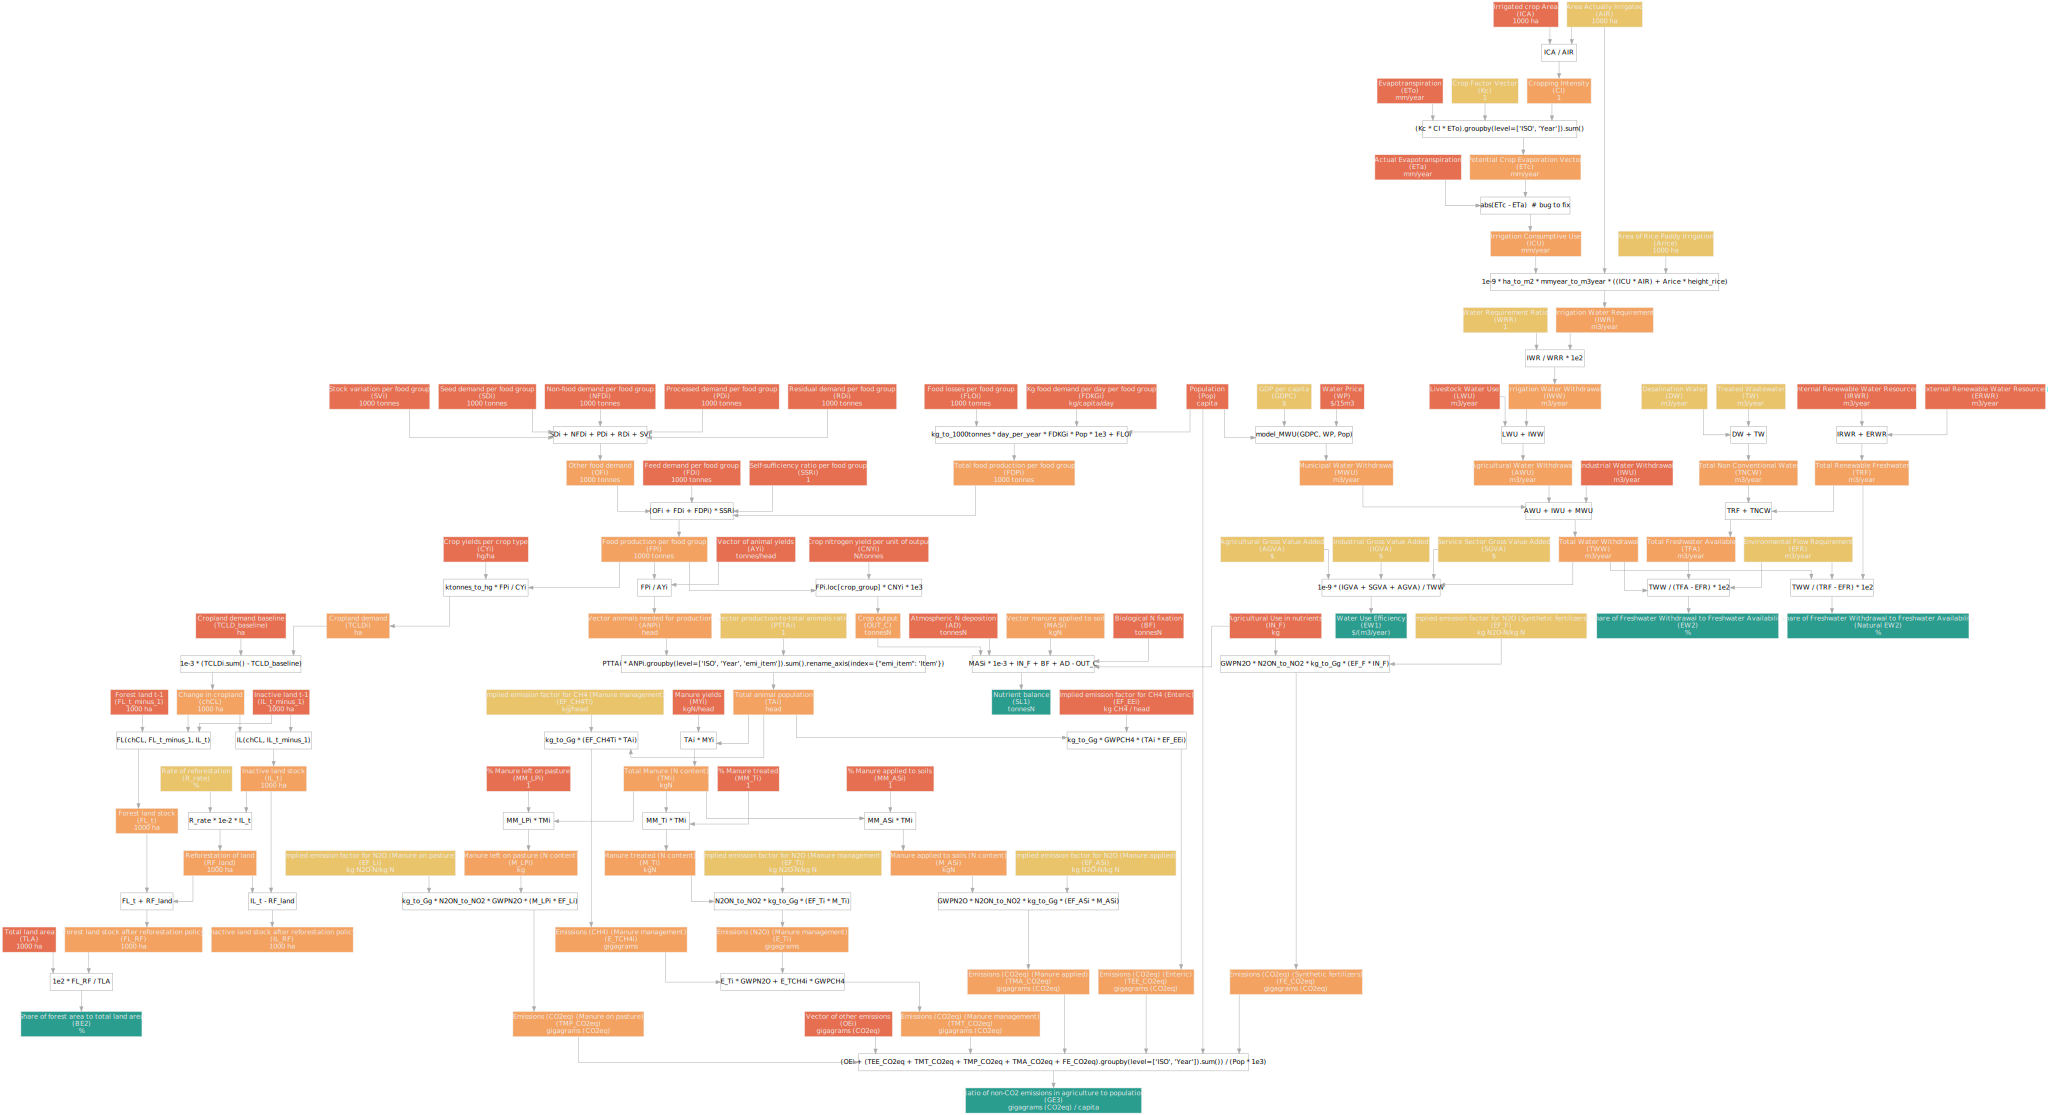

In [74]:
EXPERIMENT_model.draw()